# **Mapping Fields from 1D Channel Flow Simulation**

In [1]:
from itertools import cycle
from glob import glob
from typing import List, Tuple
from os.path import isdir
import numpy as np
import torch as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Make results reproducible
pt.manual_seed(0)
# Increase plot resolution
plt.rcParams["figure.dpi"] = 160
# Set paths and create output directory
run = "../run/"
output = "output"
!mkdir -p $output

## 1. Data loading

In [2]:
field1d_path = run + 'channelFlow1D_Re10Mil_cell1600/extractData.csv'
field1d_data = pd.read_csv(field1d_path, delim_whitespace=False)

# To transform y-coordinates (y_face) to elements of the csv file
field1d_data = field1d_data.set_index('y_face').T.rename_axis('y_face').rename_axis(None, axis=1).reset_index()
field1d_data.head()

,y_face,0.0005sec_avgU,0.0005sec_dUdy_wall,0.0005sec_dUdy_face,0.0005sec_Ux_face,0.001sec_avgU,0.001sec_dUdy_wall,0.001sec_dUdy_face,0.001sec_Ux_face,0.0015sec_avgU,...,0.096sec_dUdy_face,0.096sec_Ux_face,0.098sec_avgU,0.098sec_dUdy_wall,0.098sec_dUdy_face,0.098sec_Ux_face,0.1sec_avgU,0.1sec_dUdy_wall,0.1sec_dUdy_face,0.1sec_Ux_face
0,9.373335573e-06,2.906090,620075.954257,616298.951681,5.794478,2.690170,574004.84151,571205.438792,5.367220,2.531070,...,204902.081530,1.921267,0.952703,203279.396663,203143.576153,1.904769,0.944522,201533.806753,201401.576065,1.888424
1,1.878185898e-05,5.805322,620075.954257,591065.309923,11.474236,5.377270,574004.84151,551037.444471,10.646544,5.060655,...,203882.093402,3.844295,1.908344,203279.396663,202146.502300,3.811360,1.891968,201533.806753,200432.128693,3.778755
2,2.822570233e-05,8.635854,620075.954257,521160.885630,16.726081,8.010851,574004.84151,490563.425401,15.564902,7.546121,...,200228.934214,5.752475,2.864427,203279.396663,198582.272969,5.703570,2.839913,201533.806753,196956.749866,5.655194
3,3.770499821e-05,11.290798,620075.954257,418275.550725,21.178679,10.494537,574004.84151,393615.361927,19.755598,9.902854,...,191618.722364,7.609695,3.814834,203279.396663,190173.016164,7.546133,3.782384,201533.806753,188744.157231,7.483281
4,4.72198797e-05,13.684194,620075.954257,320747.198306,24.694536,12.737988,574004.84151,295717.671384,23.035059,12.044584,...,176443.478571,9.360729,4.749002,203279.396663,175314.737122,9.284919,4.709057,201533.806753,174197.534852,9.209954


In [3]:
# End time of OpenFOAM simulation
end_time1 = 0.01 # 20 steps with 0.0005 write interval
end_time2 = 0.1 # 45 steps with 0.002 write interval

# Number of divided time steps, not the actual time
num_step = int((len(field1d_data.columns) - 1)/4.0)

# Number of divided y-coordinates
num_yface = len(field1d_data)

# Change from string to numeric values
field1d_data['y_face'] = pd.to_numeric(field1d_data['y_face'], errors='coerce')
for i in range(num_step):    
    field1d_data.iloc[:, 4*i + 1] = pd.to_numeric(field1d_data.iloc[:, 4*i + 1], errors='coerce')
    field1d_data.iloc[:, 4*i + 2] = pd.to_numeric(field1d_data.iloc[:, 4*i + 2], errors='coerce')
    field1d_data.iloc[:, 4*i + 3] = pd.to_numeric(field1d_data.iloc[:, 4*i + 3], errors='coerce')
    field1d_data.iloc[:, 4*i + 4] = pd.to_numeric(field1d_data.iloc[:, 4*i + 4], errors='coerce')

# Save the related data to pytorch tensors
y_face = pt.tensor(field1d_data['y_face'])
avgU = pt.tensor([field1d_data.iloc[:, 4*i + 1] for i in range(num_step)]).T
dUdy_wall = pt.tensor([field1d_data.iloc[:, 4*i + 2] for i in range(num_step)]).T
dUdy_face = pt.tensor([field1d_data.iloc[:, 4*i + 3] for i in range(num_step)]).T
Ux_face = pt.tensor([field1d_data.iloc[:, 4*i + 4] for i in range(num_step)]).T

# Number of features
num_feature = 2

## 2. Verification of velocity fields

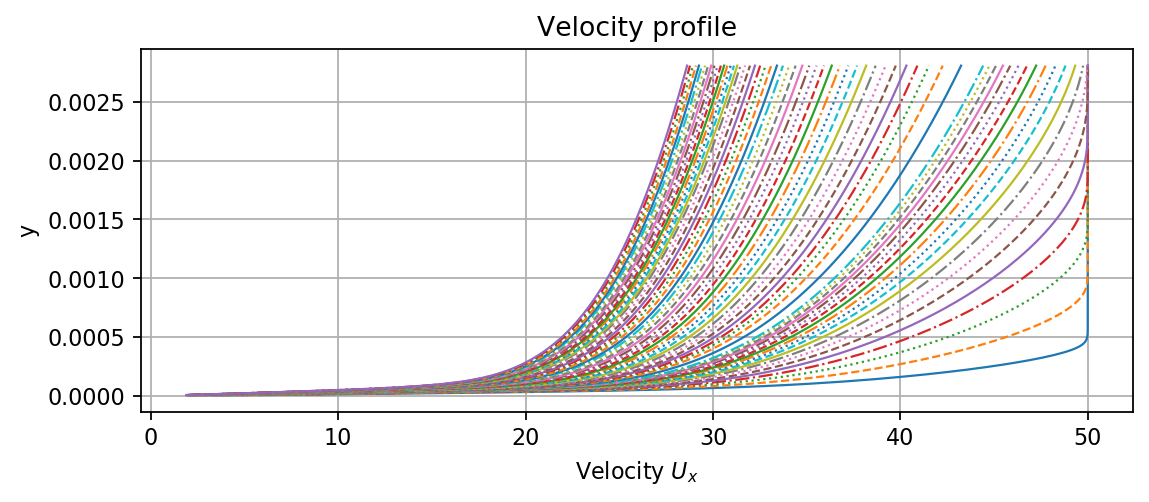

In [4]:
# Plot velocity profiles of total 65 time steps
# The end right graph corresponds to the first time step, and the end left graph is the last time step.
style = ["-", "--", ":", "-."]
lw = 1.0
stylecycler = cycle(style)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))    
plt.grid()
ax.set_xlabel(r"Velocity $U_x$")
ax.set_ylabel(r"y")
plt.title(r"Velocity profile")
for i in range(num_step):
    ax.plot(np.array(Ux_face)[:, i], np.array(y_face)[:], ls = next(stylecycler), c = "C{:d}".format(i), lw = lw)

In [5]:
# Constants
KAPPA = 0.41
E = 9.8
nu = 1.0e-5
D = 2.0 # Diameter of the channel / Length of the plate
Uinput = 50.0

# Function of Spalding's law for plotting
def spaldings_law(u_plus, E=E, kappa=KAPPA):
    """Evaluate Spalding's law of the wall.
    
    Parameters
    ----------
    u_plus - float: velocity along surface at distance y_plus in wall units
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    
    Returns
    -------
    y_plus - float: distance normal to wall in wall units
    
    """
    return u_plus + 1.0/E * (
        np.exp(kappa*u_plus) - 1.0 - kappa*u_plus - (kappa*u_plus)**2/2.0 - (kappa*u_plus)**3/6.0
    )

u_plus = np.linspace(0, 25, 100)
y_plus = np.array([spaldings_law(up) for up in u_plus])

In [6]:
# Variables for wall units
u_tau = [np.sqrt(nu*0.5*(dUdy_wall[0, i] + dUdy_face[0, i])) for i in range(num_step)]
yp = [y_face*u_tau[i]/nu for i in range(num_step)]
up = [Ux_face[:, i]/u_tau[i] for i in range(num_step)]

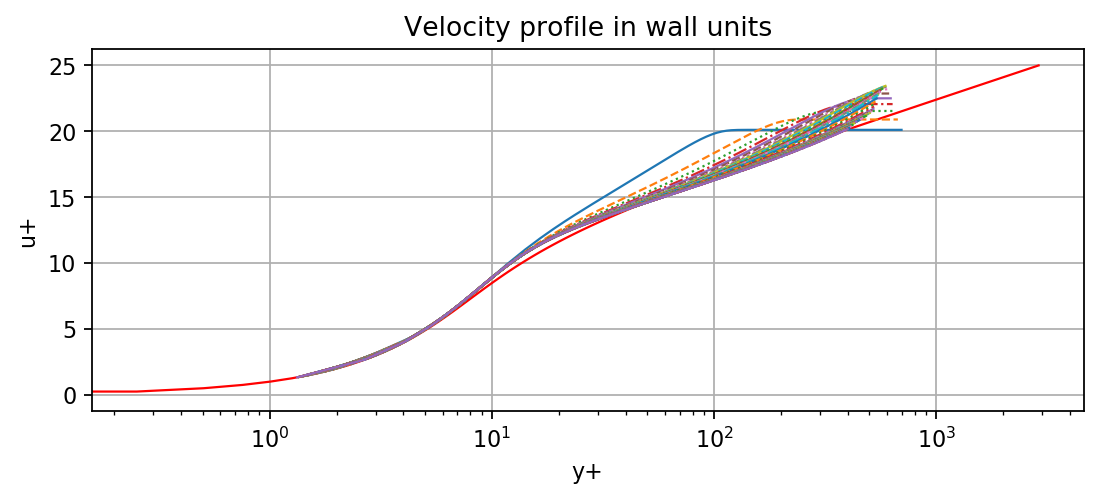

In [7]:
# Comparison of the velocity profiles of 65 time steps and Spalding's law in wall units
# (1) from 0.0005 sec to 0.01 sec, (2) from 0.012 sec to 0.1 sec
style2 = ["-", "--", ":", "-."]
lw2 = 1.0
stylecycler2 = cycle(style2)

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))    
plt.grid()
ax2.set_xscale("log")
ax2.set_xlabel(r"y+")
ax2.set_ylabel(r"u+")
plt.title(r"Velocity profile in wall units")
ax2.plot(y_plus, u_plus, label = "Spalding", ls = style2[0], c = 'r', lw = lw2)
for i in range(num_step):
    ax2.plot(np.array(yp[:][i]), np.array(up[:][i]), ls = next(stylecycler2), c = "C{:d}".format(i), lw = lw2)

## 3. Machine learning

In [8]:
# Non-dimensionalize all the data
y_face = y_face/D
avgU = avgU/Uinput
dUdy_wall = dUdy_wall*D/Uinput
dUdy_face = dUdy_face*D/Uinput
Ux_face = Ux_face/Uinput

In [9]:
# Reshape data
def reshape_data(dUdy_wall: pt.Tensor, dUdy_face: pt.Tensor, Ux_face: pt.Tensor, 
                 y_face: pt.Tensor, avgU: pt.Tensor) -> pt.Tensor:
    """Create feature and label vectors.

    Outputs
    -------
    :param dUdy_wall: velocity gradient at wall
    :type dUdy_wall: pt.Tensor
    :param dUdy_face: velocity gradient at cell faces
    :type dUdy_face: pt.Tensor
    :param Ux_face: velocity for x-direction at faces
    :type Ux_face: pt.Tensor
    
    Inputs
    ------
    :param y_face: distance from the wall at the face
    :type y: pt.Tensor
    :param avgU: average velocity profiles by integral fitting method
    :type avgU: pt.Tensor
    
    Return
    ------
    :return: data suitable for training; if there are Ny points normal to
        the wall and Nu different average velocities, the resulting tensor
        has the shape (Ny*Nu, 5)
    :rtype: pt.Tensor
    """
    assert y_face.shape[0] == avgU.shape[0]
    assert dUdy_wall.shape[1] == avgU.shape[1]
    assert dUdy_wall.shape[0] == avgU.shape[0]
    assert dUdy_face.shape[1] == avgU.shape[1]
    assert dUdy_face.shape[0] == avgU.shape[0]
    assert Ux_face.shape[1] == avgU.shape[1]
    assert Ux_face.shape[0] == avgU.shape[0]
    data = pt.zeros((avgU.shape[0]*avgU.shape[1], 5))
    for i in range(avgU.shape[1]):
        start, end = i*avgU.shape[0], (i+1)*avgU.shape[0]
        data[start:end, 0] = dUdy_wall[:, i]
        data[start:end, 1] = dUdy_face[:, i]
        data[start:end, 2] = Ux_face[:, i]
        data[start:end, 3] = y_face
        data[start:end, 4] = avgU[:, i]
    return data

In [10]:
# Exclude the examples in which the face slope is 0
# (All the labels are the same regardless of the values of features)
true_data_raw = reshape_data(dUdy_wall, dUdy_face, Ux_face, y_face, avgU)
true_data = true_data_raw[true_data_raw[:, 1] >= 1e-15]
print("Delete all the data that corresponds to the straight line at Ux = 50")
print("Original shape : {}, \t Changed shape : {}".format(true_data_raw.shape, true_data.shape))

Delete all the data that corresponds to the straight line at Ux = 50
Original shape : torch.Size([13065, 5]), 	 Changed shape : torch.Size([12694, 5])


In [11]:
# Correlation heat map for the features and the labels
true_data_pd = pd.DataFrame(np.array(true_data), columns = ['dUdy_wall','dUdy_face','Ux_face','y_face','avgU'])
data_cor = true_data_pd.corr()
data_cor.style.background_gradient(cmap='coolwarm').format(precision=4)

,dUdy_wall,dUdy_face,Ux_face,y_face,avgU
dUdy_wall,1.0000,0.1022,0.6919,-0.0667,0.6009
dUdy_face,0.1022,1.0000,-0.5017,-0.3972,-0.5540
Ux_face,0.6919,-0.5017,1.0000,0.5479,0.9891
y_face,-0.0667,-0.3972,0.5479,1.0000,0.6215
avgU,0.6009,-0.5540,0.9891,0.6215,1.0000


In [12]:
# Create a neural network
class MappingNN(pt.nn.Module):
    """Simple fully-connected neural network.
    """
    def __init__(self, **kwargs):
        super().__init__()
        self.n_inputs = kwargs.get("n_inputs", 1)
        self.n_outputs = kwargs.get("n_outputs", 1)
        self.n_layers = kwargs.get("n_layers", 1)
        self.n_neurons = kwargs.get("n_neurons", 10)
        self.activation = kwargs.get("activation", pt.sigmoid)
        self.layers = pt.nn.ModuleList()
        # Input layer to first hidden layer
        self.layers.append(pt.nn.Linear(self.n_inputs, self.n_neurons))
        # Add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(pt.nn.Linear(
                    self.n_neurons, self.n_neurons))
        # Last hidden layer to output layer
        self.layers.append(pt.nn.Linear(self.n_neurons, self.n_outputs))

    def forward(self, x):
        for i_layer in range(len(self.layers)-1):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

    @property
    def model_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [13]:
# Divide the data into 3 parts by using a multinomial method
# 60% train, 20% validation, 20% test sets
probs = pt.ones(dUdy_wall.shape[-1])
test_idx = pt.multinomial(probs, 13)
probs[test_idx] = 0.0
val_idx = pt.multinomial(probs, 13)
probs[val_idx] = 0.0
train_idx = pt.multinomial(probs, probs.shape[0] - 26)
print("Testing snapshots: ", test_idx)
print("Validation snapshots: ", val_idx)
print("Training snapshots: ", train_idx)

Testing snapshots:  tensor([58, 47, 41, 61, 22, 33, 62, 11,  6, 52, 32, 17, 20])
Validation snapshots:  tensor([ 9, 63, 28, 50, 59, 57, 64,  3,  0, 48, 14, 12, 35])
Training snapshots:  tensor([38, 40,  5,  1, 10, 53, 49, 37, 16, 54, 46,  4, 30, 26, 55,  2, 44, 39,
         8, 27, 60, 15, 24, 42, 45, 19, 29, 13, 23, 25,  7, 18, 51, 31, 34, 21,
        43, 56, 36])


In [14]:
# Normalization of data
class MinMaxScaler(object):
    """Class to scale/re-scale data to the range [0, 1] and back.
    """
    def __init__(self):
        self.min = None
        self.max = None
        self.trained = False

    def fit(self, data):
        self.min = data.min(dim=0).values
        self.max = data.max(dim=0).values
        self.trained = True

    def scale(self, data):
        assert self.trained        
        assert len(data.shape) == 2
        data_norm = (data - self.min) / (self.max - self.min)
        return data_norm

    def rescale(self, data_norm):
        assert self.trained        
        assert len(data_norm.shape) == 2
        data = data_norm * (self.max - self.min) + self.min
        return data

In [15]:
test_data = reshape_data(dUdy_wall[:, test_idx], dUdy_face[:, test_idx], Ux_face[:, test_idx], y_face, avgU[:, test_idx])
val_data = reshape_data(dUdy_wall[:, val_idx], dUdy_face[:, val_idx], Ux_face[:, val_idx], y_face, avgU[:, val_idx])
train_data = reshape_data(dUdy_wall[:, train_idx], dUdy_face[:, train_idx], Ux_face[:, train_idx], y_face, avgU[:, train_idx])

# Delete examples in which the face slope is 0
test_data = test_data[test_data[:, 1] >= 1e-15]
val_data = val_data[val_data[:, 1] >= 1e-15]
train_data = train_data[train_data[:, 1] >= 1e-15]

# Use float64 type
test_data = test_data.double()
val_data = val_data.double()
train_data = train_data.double()

In [16]:
# Check if the normalization works
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_norm = scaler.scale(train_data)
val_data_norm = scaler.scale(val_data)
test_data_norm = scaler.scale(test_data)

assert pt.isclose(train_data_norm.min(), pt.tensor(0.0).double())
assert pt.isclose(train_data_norm.max(), pt.tensor(1.0).double())
assert pt.allclose(train_data, scaler.rescale(train_data_norm))

In [17]:
# Model optimization function
def optimize_model(model: pt.nn.Module, x_train: pt.Tensor, y_train: pt.Tensor,
                   x_val: pt.Tensor, y_val: pt.Tensor, epochs: int=1000,
                   lr: float=0.001, save_best: str="") ->Tuple[List[float], List[float]]:
    """Optimize network weights based on training and validation data.

    Parameters
    ----------
    :param model: neural network model
    :type model: pt.nn.Module
    :param x_train: features for training
    :type x_train: pt.Tensor
    :param y_train: labels for training
    :type y_train: pt.Tensor
    :param x_val: features for validation
    :type x_val: pt.Tensor
    :param y_val: labels for validation
    :type y_val: pt.Tensor
    :param epochs: number of optimization loops, defaults to 1000
    :type epochs: int, optional
    :param lr: learning rate, defaults to 0.001
    :type lr: float, optional
    :param save_best: path where to save best model; no snapshots are saved
        if empty string; defaults to ""
    :type save_best: str, optional
    
    Return
    ------
    :return: lists with training and validation losses for all epochs
    :rtype: Tuple[List[float], List[float]]
    """
    criterion = pt.nn.MSELoss()
    optimizer = pt.optim.Adam(params=model.parameters(), lr=lr)
    best_val_loss, best_train_loss = 1.0e5, 1.0e5
    train_loss, val_loss = [], []
    for e in range(1, epochs+1):
        optimizer.zero_grad()
        prediction = model(x_train).squeeze()
        pt.clamp(prediction, min = 1e-15) # Limit the minimum value of the prediction
        loss = criterion(prediction, y_train)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        with pt.no_grad():
            prediction = model(x_val).squeeze()
            pt.clamp(prediction, min = 1e-15) # Limit the minimum value of the prediction
            loss = criterion(prediction, y_val)
            val_loss.append(loss.item())        
        if isdir(save_best):
            if train_loss[-1] < best_train_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_train.pt")
                best_train_loss = train_loss[-1]
            if val_loss[-1] < best_val_loss:
                pt.save(model.state_dict(), f"{save_best}best_model_val.pt")
                best_val_loss = val_loss[-1]
    print("\r", "Training/validation loss epoch {:5d}: {:10.5e}, {:10.5e}".format(
            epochs, train_loss[-1], val_loss[-1]), end="")
    return train_loss, val_loss

In [18]:
# First model training with normalized data
save_model_in = f"{output}/first_training_1D/"
!mkdir -p $save_model_in
model_params = {
    "n_inputs": 2,
    "n_outputs": 3,
    "n_layers": 2,
    "n_neurons": 40,
    "activation": pt.nn.ReLU()
}
model = MappingNN(**model_params)
model = model.double()
train_loss, val_loss = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3],
                                      val_data_norm[:, 3:], val_data_norm[:, 0:3], 20000, save_best=save_model_in)

 Training/validation loss epoch 20000: 1.28923e-05, 4.09571e-05

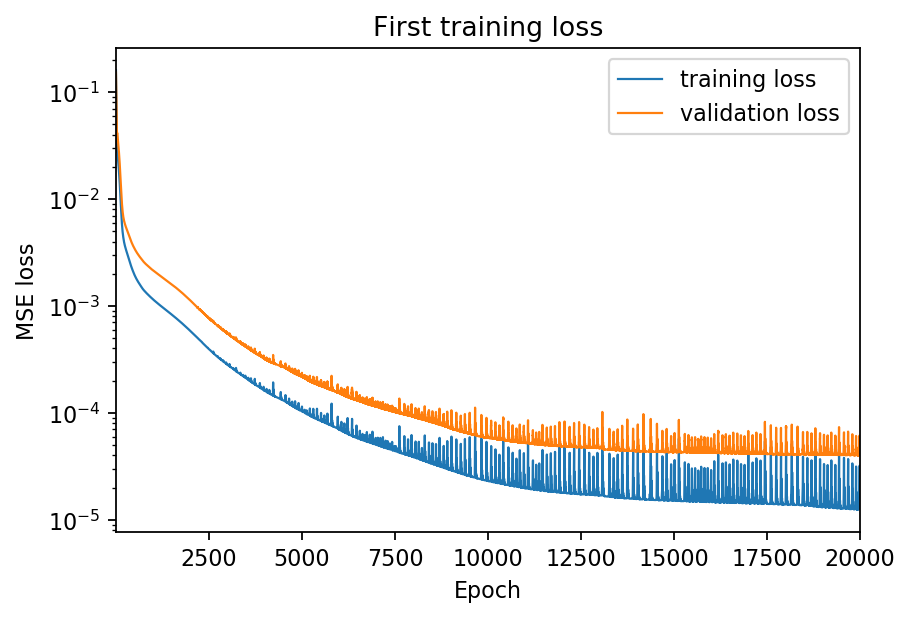

In [19]:
epochs = len(train_loss)
plt.title("First training loss")
plt.plot(range(1, epochs+1), train_loss, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss, lw=1.0, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss.svg", bbox_inches="tight")

In [20]:
# Calculate L_inf
best_model = MappingNN(**model_params)
best_model = best_model.double()
best_model.load_state_dict(pt.load(f"{save_model_in}best_model_train.pt"))
prediction = best_model(test_data_norm[:, 3:]).squeeze()
l2 = (prediction - test_data_norm[:, 0:3]).square().mean()
# We normalize the maximum error with the range of the scaled dUdy and Ux_face,
# which is 1 - 0 = 1
lmax = (prediction - test_data_norm[:, 0:3]).absolute().max()
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 1.2475e-05
Lmax test loss: 4.1230e-02


In [21]:
# Comparison between the original and trained data
full_data = reshape_data(dUdy_wall, dUdy_face, Ux_face, y_face, avgU)
full_data = full_data[full_data[:, 1] >= 1e-15]
full_data_norm = scaler.scale(full_data)

# Save the tracing model for OpenFOAM
traced_script_module = pt.jit.trace(best_model, full_data_norm[:, 3:])
traced_script_module.save(f"{save_model_in}first_traced_model.pt")

full_pred = best_model(full_data_norm[:, 3:]).squeeze()
# Re-use full dataset for rescaling; it would be better to have separate scalers for features and labels
full_data_norm[:, 0:3] = full_pred
prediction = scaler.rescale(full_data_norm).detach()

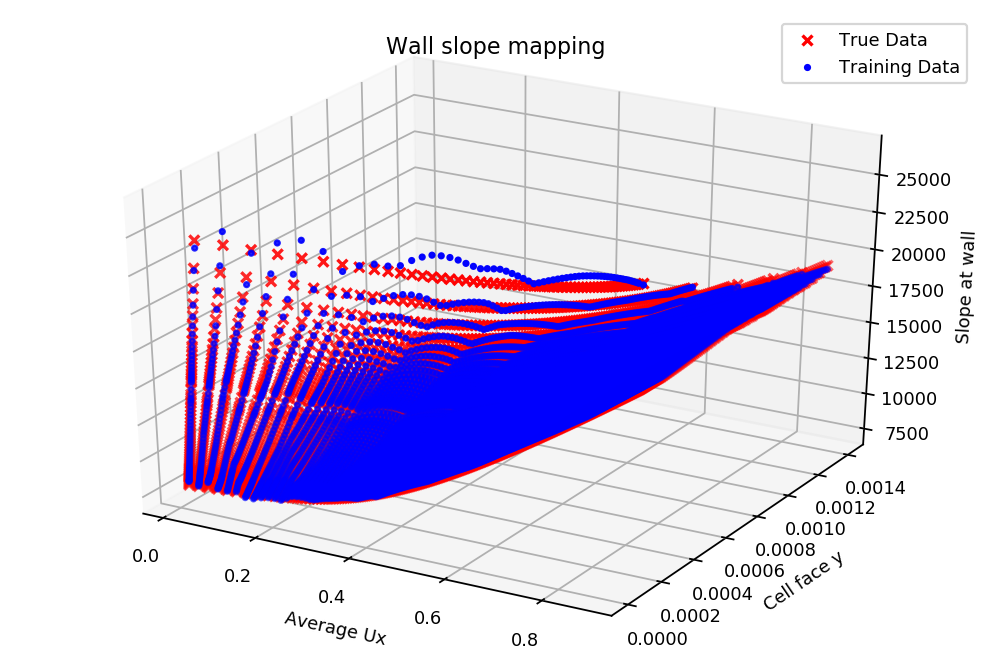

In [22]:
# Plot true label and trained model for wall slope
fig_map = plt.figure()
ax_map = Axes3D(fig_map)

ax_map.set_title('Wall slope mapping', fontsize=10)
ax_map.set_xlabel('Average Ux', fontsize=8)
ax_map.set_ylabel('Cell face y', fontsize=8)
ax_map.set_zlabel('Slope at wall', fontsize=8)
ax_map.xaxis.set_tick_params(labelsize=8)
ax_map.yaxis.set_tick_params(labelsize=8)
ax_map.zaxis.set_tick_params(labelsize=8)
ax_map.scatter(full_data[:, 4], full_data[:, 3], full_data[:, 0], color = "r", marker = "x", label = "True Data")
ax_map.scatter(full_data[:, 4], full_data[:, 3], prediction[:, 0], color = 'b', marker = ".", label = "Training Data")
ax_map.legend(fontsize = 8)

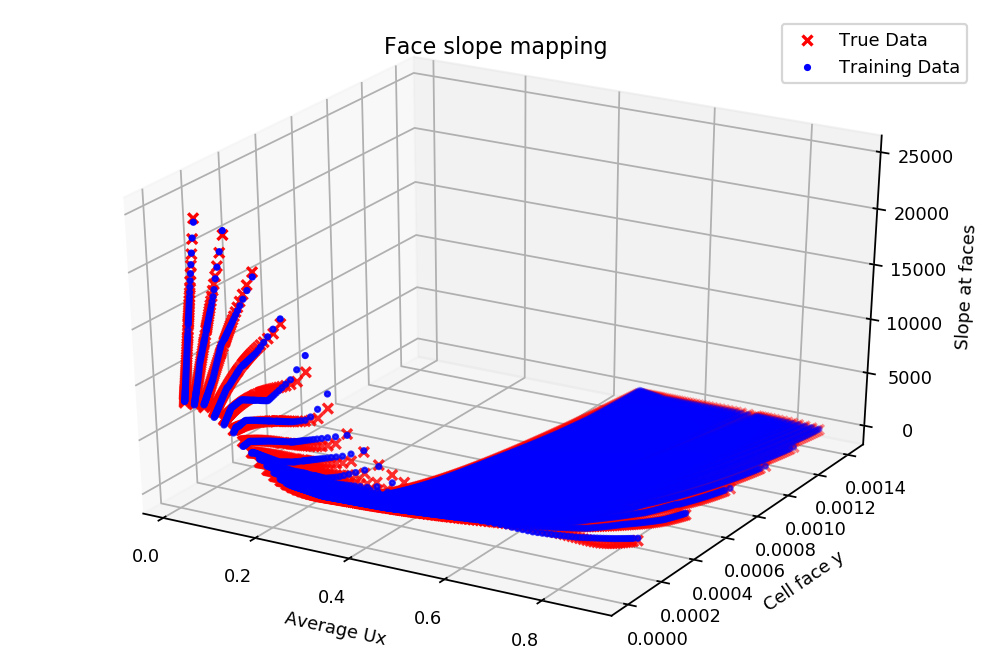

In [23]:
# Plot true label and trained model for face slope
fig_map2 = plt.figure()
ax_map2 = Axes3D(fig_map2)

ax_map2.set_title('Face slope mapping', fontsize=10)
ax_map2.set_xlabel('Average Ux', fontsize=8)
ax_map2.set_ylabel('Cell face y', fontsize=8)
ax_map2.set_zlabel('Slope at faces', fontsize=8)
ax_map2.xaxis.set_tick_params(labelsize=8)
ax_map2.yaxis.set_tick_params(labelsize=8)
ax_map2.zaxis.set_tick_params(labelsize=8)
ax_map2.scatter(full_data[:, 4], full_data[:, 3], full_data[:, 1], color = "r", marker = "x", label = "True Data")
ax_map2.scatter(full_data[:, 4], full_data[:, 3], prediction[:, 1], color = 'b', marker = ".", label = "Training Data")
ax_map2.legend(fontsize = 8)

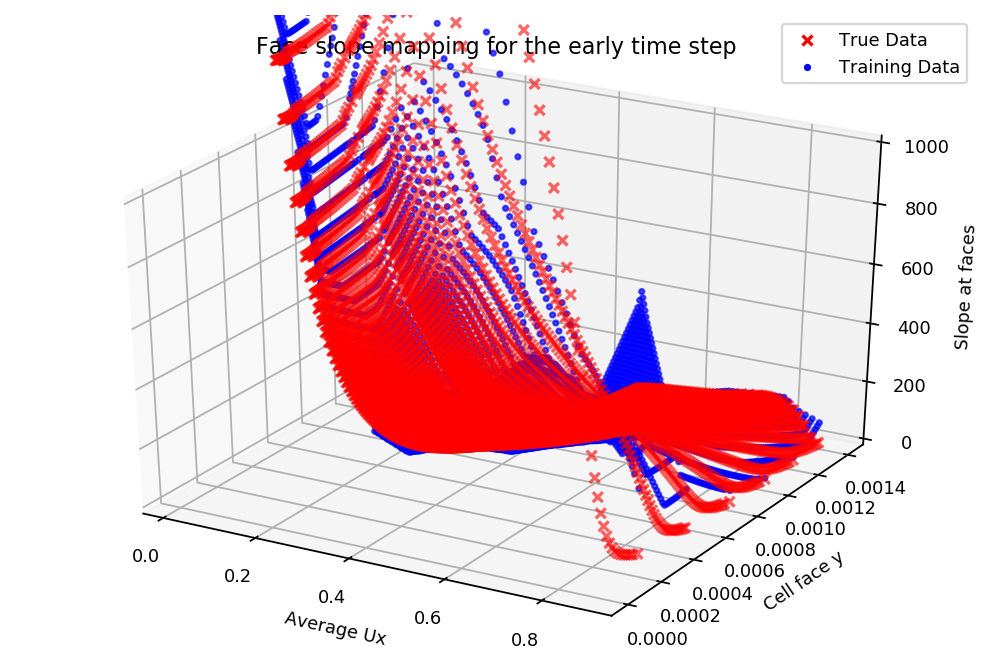

In [24]:
# Plot specifically true label and trained model for face slope for the early time step
fig_map2_add = plt.figure()
ax_map2_add = Axes3D(fig_map2_add)

ax_map2_add.set_title('Face slope mapping for the early time step', fontsize=10)
ax_map2_add.set_xlabel('Average Ux', fontsize=8)
ax_map2_add.set_ylabel('Cell face y', fontsize=8)
ax_map2_add.set_zlabel('Slope at faces', fontsize=8)
ax_map2_add.xaxis.set_tick_params(labelsize=8)
ax_map2_add.yaxis.set_tick_params(labelsize=8)
ax_map2_add.zaxis.set_tick_params(labelsize=8)
ax_map2_add.set_zlim([0, 1000])
ax_map2_add.scatter(full_data[:, 4], full_data[:, 3], full_data[:, 1], color = "r", marker = "x", label = "True Data")
ax_map2_add.scatter(full_data[:, 4], full_data[:, 3], prediction[:, 1], color = 'b', marker = ".", label = "Training Data")
ax_map2_add.legend(fontsize = 8)

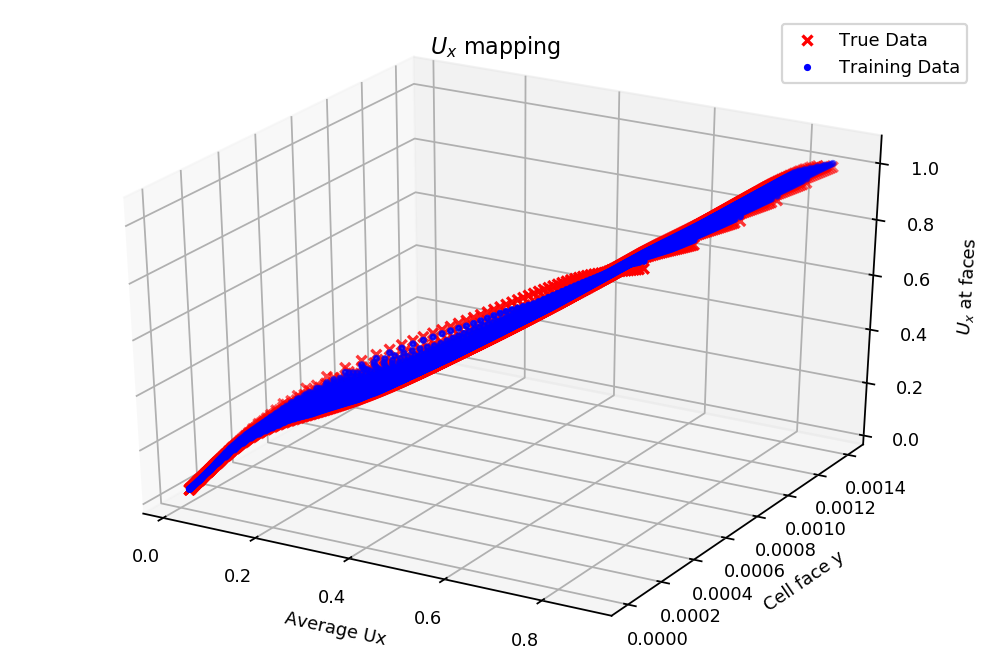

In [25]:
# Plot true label and trained model for Ux at faces
fig_map3 = plt.figure()
ax_map3= Axes3D(fig_map3)

ax_map3.set_title(r'$U_x$ mapping', fontsize=10)
ax_map3.set_xlabel('Average Ux', fontsize=8)
ax_map3.set_ylabel('Cell face y', fontsize=8)
ax_map3.set_zlabel(r'$U_x$ at faces', fontsize=8)
ax_map3.xaxis.set_tick_params(labelsize=8)
ax_map3.yaxis.set_tick_params(labelsize=8)
ax_map3.zaxis.set_tick_params(labelsize=8)
ax_map3.scatter(full_data[:, 4], full_data[:, 3], full_data[:, 2], color = "r", marker = "x", label = "True Data")
ax_map3.scatter(full_data[:, 4], full_data[:, 3], prediction[:, 2], color = 'b', marker = ".", label = "Training Data")
ax_map3.legend(fontsize = 8)

## 4. Check uncertainties

For checking the general trend of uncertainties of the neural network model

### 4-1. For activation functions

In [26]:
# Epochs for checking uncertainties
epoch_uncert = 10000

# Evaluate the best model
def eval_best_model(model: pt.nn.Module, features: pt.Tensor,
                    label: pt.Tensor, path: str) -> float:
    """Helper function to load and evaluate model snapshot.

    Parameters
    ----------
    :param model: neural network model
    :type model: pt.nn.Module
    :param features: feature tensor
    :type features: pt.Tensor
    :param label: label tensor
    :type label: pt.Tensor
    :param path: location where the best model is stored
    :type path: str
    
    Return
    ------
    :return: mean squared prediction error
    :rtype: float
    """
    model.load_state_dict(pt.load(f"{path}best_model_train.pt"))
    prediction = model(features).squeeze()
    return (prediction - label).square().mean().detach().item()

In [25]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
activations = [pt.sigmoid, pt.tanh, pt.nn.ELU(), pt.nn.ReLU(), pt.nn.SELU()]
losses = [[], [], [], [], []]
for i, activation in enumerate(activations):
    model_params["activation"] = activation
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], epoch_uncert, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch 10000: 1.51448e-04, 9.62962e-04

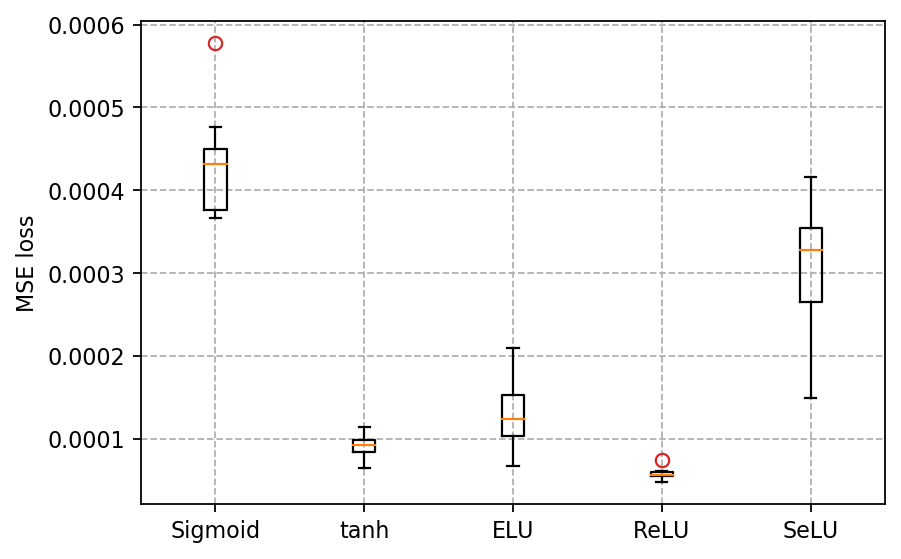

In [26]:
# Box plot
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})    

plt.gca().set_xticklabels(["Sigmoid", "tanh", "ELU", "ReLU", "SeLU"])
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_activations.svg", bbox_inches="tight")

### 4-2. For number of layers

In [27]:
save_temp = f"{output}/temp_1D/"
!mkdir -p $save_temp
layers = [3, 4, 5, 6]
losses = [[], [], [], []]
model_params["activation"] = pt.nn.ReLU()
for i, nl in enumerate(layers):
    model_params["n_layers"] = nl
    for seed in range(10):
        pt.manual_seed(seed)
        model = MappingNN(**model_params)
        _, _ = optimize_model(model, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = 0.0003, epochs = epoch_uncert, save_best=save_temp)
        losses[i].append(
            eval_best_model(
                model, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch 10000: 4.26416e-05, 5.74593e-04

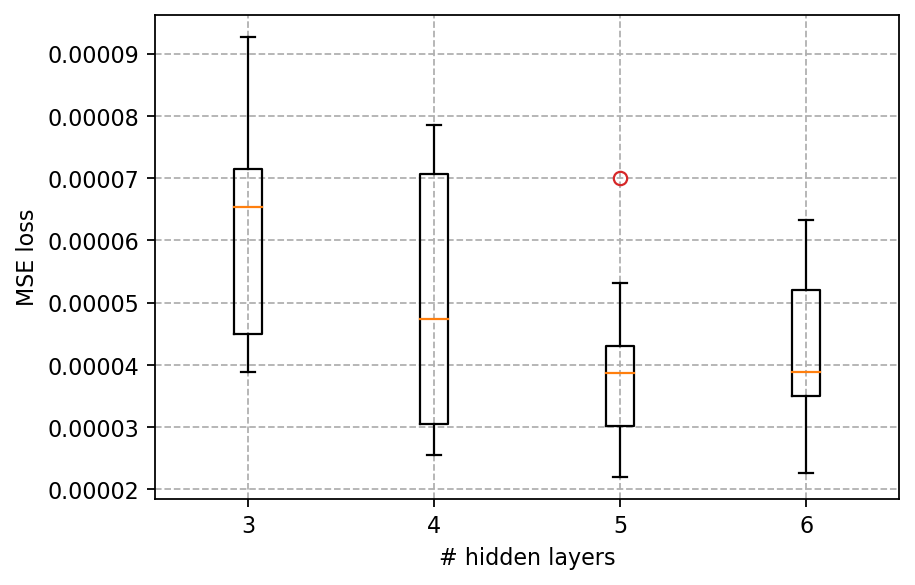

In [28]:
for i in range(len(losses)):
    plt.boxplot(np.array(losses[i]), positions=[layers[i]], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("# hidden layers")
plt.ylabel("MSE loss")
plt.grid(ls="--")
plt.savefig(f"{output}/profile_layers.svg", bbox_inches="tight")

### 4-3. For learning rate

In [57]:
save_temp = f"{output}/temp_1D_lr/"
!mkdir -p $save_temp
lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01]
losses_lr = [[], [], [], [], []]
model_params["activation"] = pt.nn.ReLU()
model_params["n_layers"] = 3
for i, lr in enumerate(lrs):    
    for seed in range(10):
        pt.manual_seed(seed)
        model_lr = MappingNN(**model_params)
        _, _ = optimize_model(model_lr, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = lr, epochs = epoch_uncert, save_best=save_temp)
        losses_lr[i].append(
            eval_best_model(
                model_lr, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch 10000: 1.61321e-04, 7.73853e-04

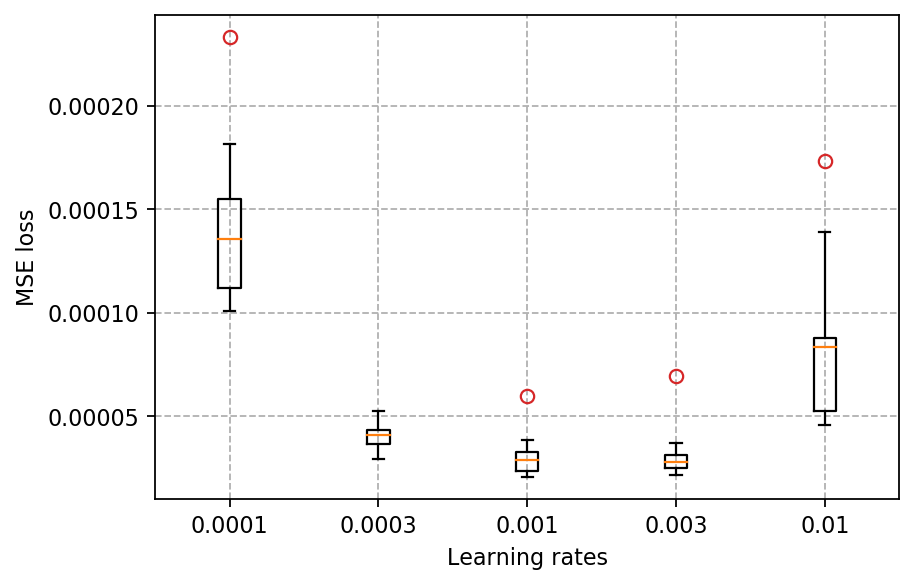

In [58]:
for i in range(len(losses_lr)):
    plt.boxplot(np.array(losses_lr[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("Learning rates")
plt.ylabel("MSE loss")
plt.gca().set_xticklabels([lrs[0], lrs[1], lrs[2], lrs[3], lrs[4]])
plt.grid(ls="--")
plt.savefig(f"{output}/profile_learningrates.svg", bbox_inches="tight")

### 4-4. For number of neurons per layer

In [59]:
save_temp = f"{output}/temp_1D_neurons/"
!mkdir -p $save_temp
neurons = [20, 30, 40, 50]
losses_nr = [[], [], [], []]
model_params["activation"] = pt.nn.ReLU()
model_params["n_layers"] = 3
for i, nr in enumerate(neurons):
    model_params["n_neurons"] = nr
    for seed in range(10):
        pt.manual_seed(seed)
        model_nr = MappingNN(**model_params)
        _, _ = optimize_model(model_nr, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = 0.0003, epochs = epoch_uncert, save_best=save_temp)
        losses_nr[i].append(
            eval_best_model(
                model_nr, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp)
        )

 Training/validation loss epoch 10000: 3.05103e-05, 1.31689e-03

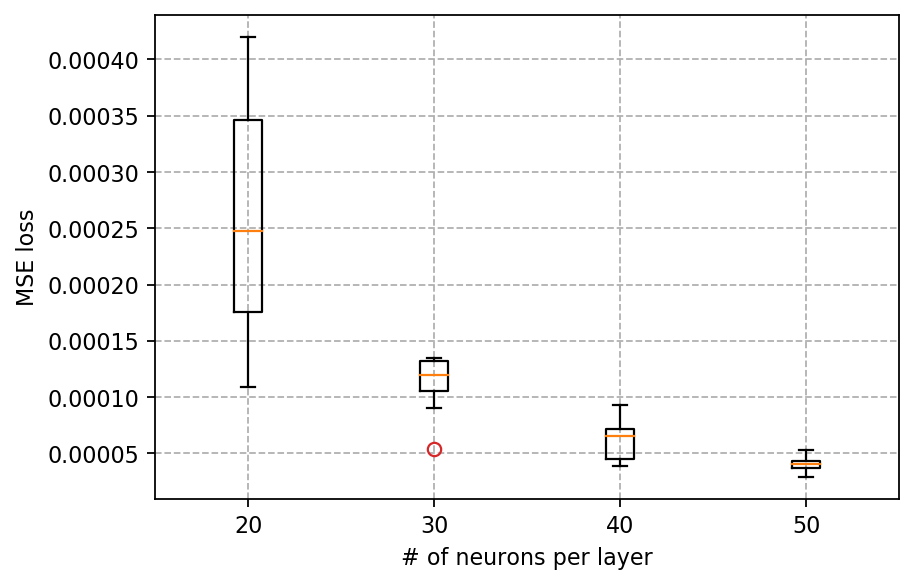

In [60]:
for i in range(len(losses_nr)):
    plt.boxplot(np.array(losses_nr[i]), positions=[i], flierprops={
                "markersize": 6, "markeredgecolor": "C3"})

plt.xlabel("# of neurons per layer")
plt.ylabel("MSE loss")
plt.gca().set_xticklabels([neurons[0], neurons[1], neurons[2], neurons[3]])
plt.grid(ls="--")
plt.savefig(f"{output}/profile_neurons.svg", bbox_inches="tight")

#### The best model is,

lr = 0.001 or 0.003, number of neurons per layer = 50, number of hidden layers = 5, activation function = ReLU.

Now, the second training is to be started with lr = 0.001.

In [27]:
# The best model training with normalized data
save_model_best = f"{output}/best_training_1D/"
!mkdir -p $save_model_best
model_params = {
    "n_inputs": 2,
    "n_outputs": 3,
    "n_layers": 5,
    "n_neurons": 50,
    "activation": pt.nn.ReLU()
}
model2 = MappingNN(**model_params)
model2 = model2.double()
train_loss2, val_loss2 = optimize_model(model2, train_data_norm[:, 3:], train_data_norm[:, 0:3],
                                      val_data_norm[:, 3:], val_data_norm[:, 0:3], lr = 0.001, epochs = 20000, 
                                      save_best=save_model_best)

 Training/validation loss epoch 20000: 4.02257e-06, 4.84283e-05

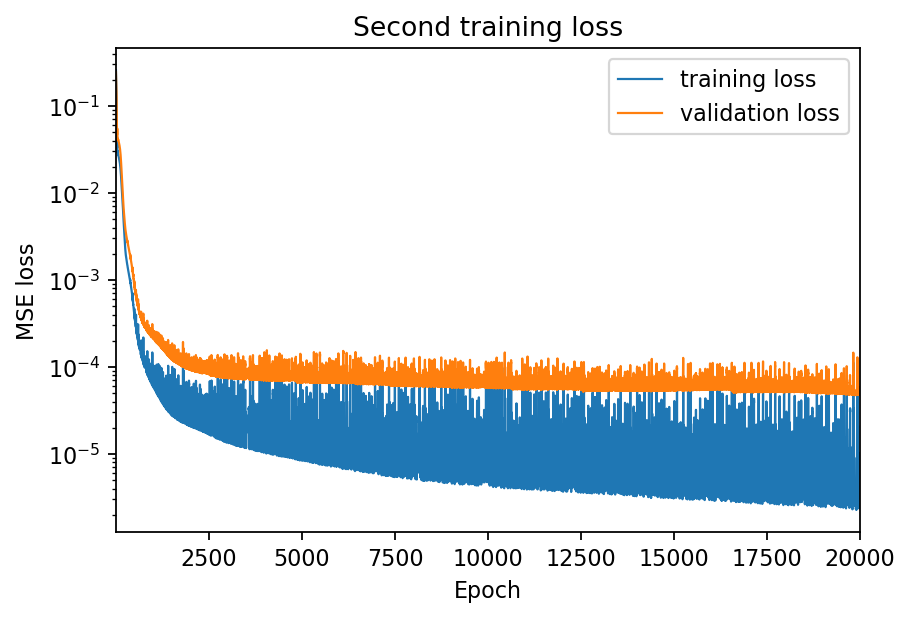

In [28]:
epochs = len(train_loss2)
plt.title("Second training loss")
plt.plot(range(1, epochs+1), train_loss2, lw=1.0, label="training loss")
plt.plot(range(1, epochs+1), val_loss2, lw=1.0, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.xlim(1, epochs+1)
plt.yscale("log")
plt.legend()
plt.savefig(f"{output}/train_val_loss_best.svg", bbox_inches="tight")

In [29]:
# Calculate L_inf again
best_model2 = MappingNN(**model_params)
best_model2 = best_model2.double()
best_model2.load_state_dict(pt.load(f"{save_model_best}best_model_train.pt"))
prediction2 = best_model2(test_data_norm[:, 3:]).squeeze()
l2 = (prediction2 - test_data_norm[:, 0:3]).square().mean()
# We normalize the maximum error with the range of the scaled dUdy and Ux_face,
# which is 1 - 0 = 1
lmax = (prediction2 - test_data_norm[:, 0:3]).absolute().max()
print("MSE test loss: {:1.4e}".format(l2))
print("Lmax test loss: {:1.4e}".format(lmax))

MSE test loss: 3.2371e-06
Lmax test loss: 2.2051e-02


In [30]:
# Comparison between the original and trained data
full_data2 = reshape_data(dUdy_wall, dUdy_face, Ux_face, y_face, avgU)
full_data2 = full_data2[full_data2[:, 1] >= 1e-15]
full_data_norm2 = scaler.scale(full_data2)

# Save the tracing model for OpenFOAM
traced_script_module2 = pt.jit.trace(best_model2, full_data_norm2[:, 3:])
traced_script_module2.save(f"{save_model_best}best_traced_model.pt")

full_pred2 = best_model2(full_data_norm2[:, 3:]).squeeze()
# Re-use full dataset for rescaling; it would be better to have separate scalers for features and labels
full_data_norm2[:, 0:3] = full_pred2
prediction2 = scaler.rescale(full_data_norm2).detach()

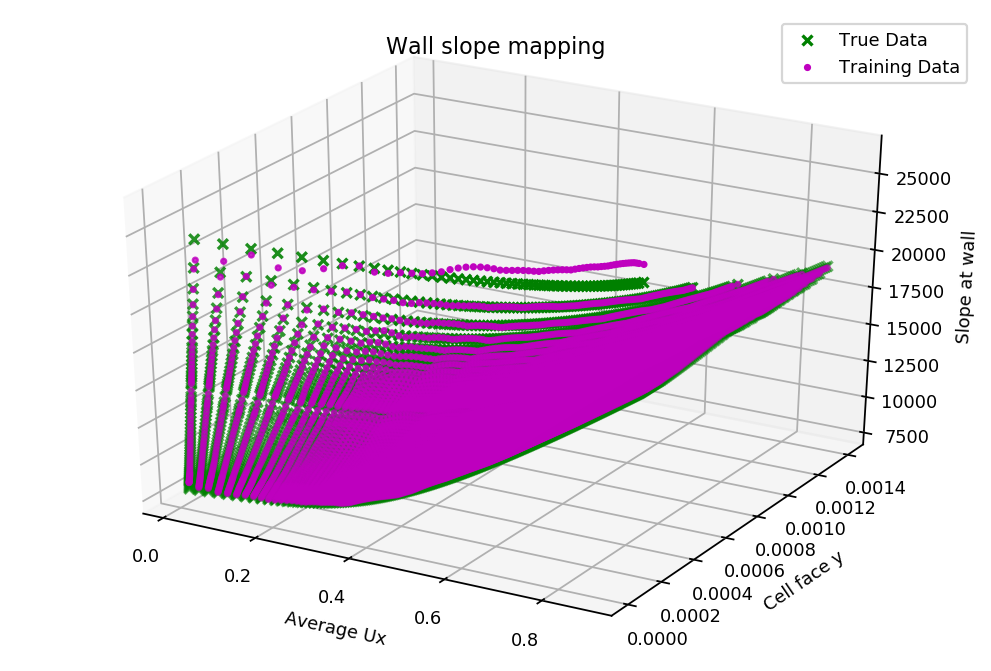

In [31]:
# Plot true label and trained model for wall slope
fig_map_best = plt.figure()
ax_map_best = Axes3D(fig_map_best)

ax_map_best.set_title('Wall slope mapping', fontsize=10)
ax_map_best.set_xlabel('Average Ux', fontsize=8)
ax_map_best.set_ylabel('Cell face y', fontsize=8)
ax_map_best.set_zlabel('Slope at wall', fontsize=8)
ax_map_best.xaxis.set_tick_params(labelsize=8)
ax_map_best.yaxis.set_tick_params(labelsize=8)
ax_map_best.zaxis.set_tick_params(labelsize=8)
ax_map_best.scatter(full_data2[:, 4], full_data2[:, 3], full_data2[:, 0], color = "g", marker = "x", label = "True Data")
ax_map_best.scatter(full_data2[:, 4], full_data2[:, 3], prediction2[:, 0], color = 'm', marker = ".", label = "Training Data")
ax_map_best.legend(fontsize = 8)

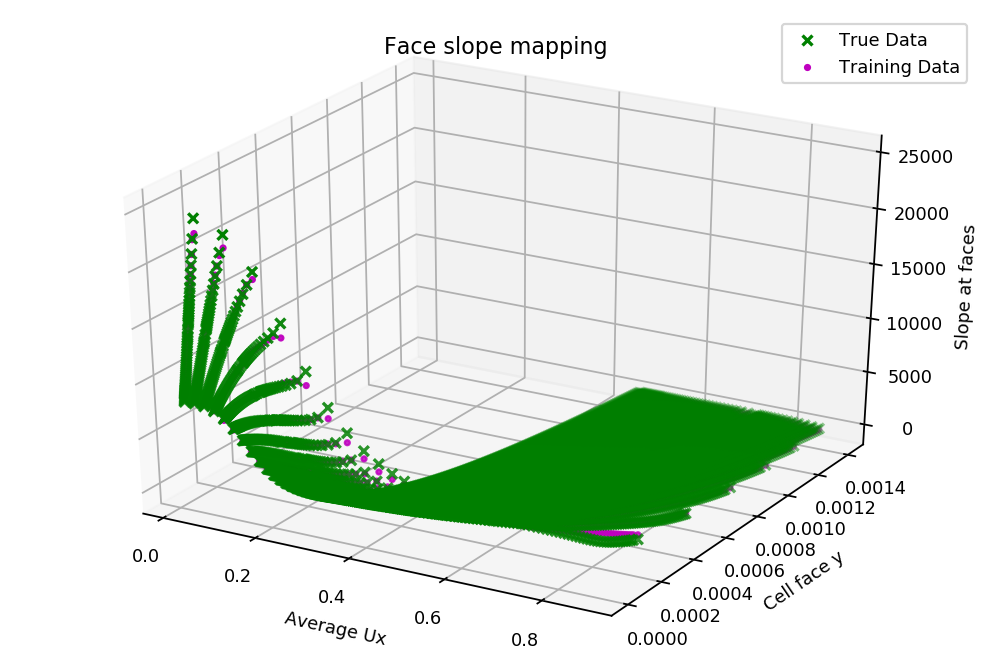

In [32]:
# Plot true label and trained model for face slope
fig_map_best2 = plt.figure()
ax_map_best2 = Axes3D(fig_map_best2)

ax_map_best2.set_title('Face slope mapping', fontsize=10)
ax_map_best2.set_xlabel('Average Ux', fontsize=8)
ax_map_best2.set_ylabel('Cell face y', fontsize=8)
ax_map_best2.set_zlabel('Slope at faces', fontsize=8)
ax_map_best2.xaxis.set_tick_params(labelsize=8)
ax_map_best2.yaxis.set_tick_params(labelsize=8)
ax_map_best2.zaxis.set_tick_params(labelsize=8)
ax_map_best2.scatter(full_data2[:, 4], full_data2[:, 3], full_data2[:, 1], color = "g", marker = "x", label = "True Data")
ax_map_best2.scatter(full_data2[:, 4], full_data2[:, 3], prediction2[:, 1], color = 'm', marker = ".", label = "Training Data")
ax_map_best2.legend(fontsize = 8)

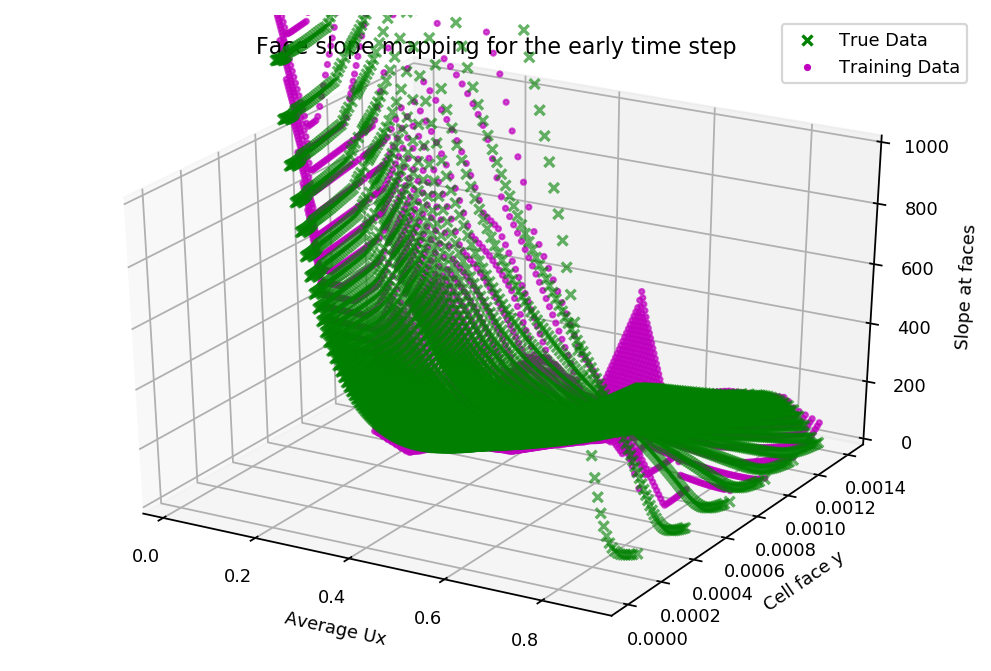

In [33]:
# Plot specifically true label and trained model for face slope for the early time step
fig_map_best2_add = plt.figure()
ax_map_best2_add = Axes3D(fig_map_best2_add)

ax_map_best2_add.set_title('Face slope mapping for the early time step', fontsize=10)
ax_map_best2_add.set_xlabel('Average Ux', fontsize=8)
ax_map_best2_add.set_ylabel('Cell face y', fontsize=8)
ax_map_best2_add.set_zlabel('Slope at faces', fontsize=8)
ax_map_best2_add.xaxis.set_tick_params(labelsize=8)
ax_map_best2_add.yaxis.set_tick_params(labelsize=8)
ax_map_best2_add.zaxis.set_tick_params(labelsize=8)
ax_map_best2_add.set_zlim([0, 1000])
ax_map_best2_add.scatter(full_data[:, 4], full_data[:, 3], full_data[:, 1], color = "g", marker = "x", label = "True Data")
ax_map_best2_add.scatter(full_data[:, 4], full_data[:, 3], prediction[:, 1], color = 'm', marker = ".", label = "Training Data")
ax_map_best2_add.legend(fontsize = 8)

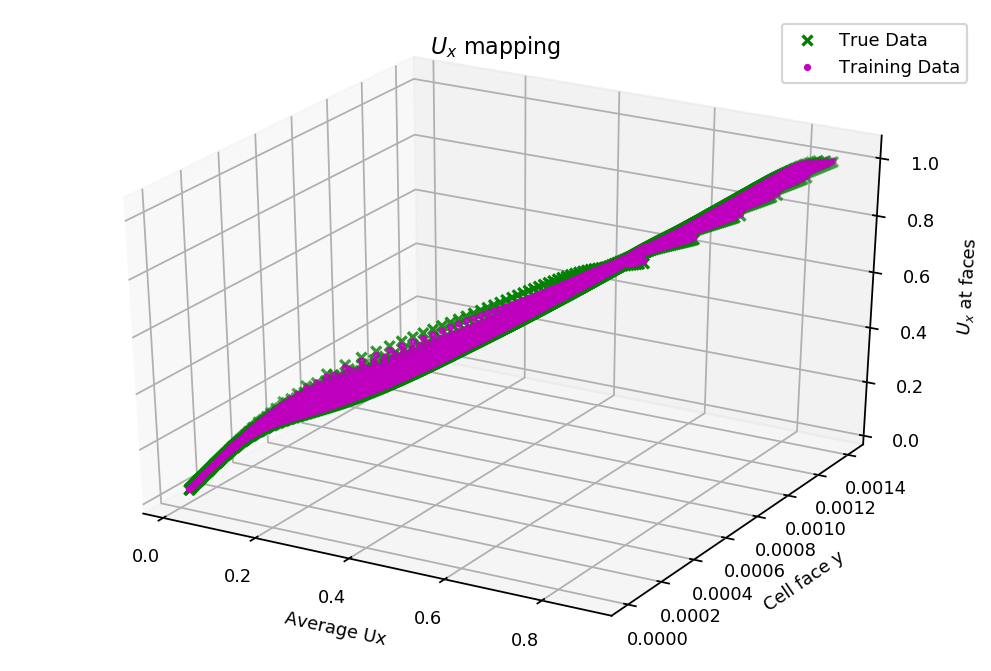

In [34]:
# Plot true label and trained model for Ux at faces
fig_map_best3 = plt.figure()
ax_map_best3= Axes3D(fig_map_best3)

ax_map_best3.set_title(r'$U_x$ mapping', fontsize=10)
ax_map_best3.set_xlabel('Average Ux', fontsize=8)
ax_map_best3.set_ylabel('Cell face y', fontsize=8)
ax_map_best3.set_zlabel(r'$U_x$ at faces', fontsize=8)
ax_map_best3.xaxis.set_tick_params(labelsize=8)
ax_map_best3.yaxis.set_tick_params(labelsize=8)
ax_map_best3.zaxis.set_tick_params(labelsize=8)
ax_map_best3.scatter(full_data2[:, 4], full_data2[:, 3], full_data2[:, 2], color = "g", marker = "x", label = "True Data")
ax_map_best3.scatter(full_data2[:, 4], full_data2[:, 3], prediction2[:, 2], color = 'm', marker = ".", label = "Training Data")
ax_map_best3.legend(fontsize = 8)

## 5. Prediction error of the best model

In [35]:
save_temp_best = f"{output}/temp_1D_best/"
!mkdir -p $save_temp_best

neurons = 50
hidden = 5
lr = 0.001

losses_best = [[]]
model_params["activation"] = pt.nn.ReLU()
model_params["n_neurons"] = neurons
model_params["n_layers"] = hidden
for seed in range(10):
    pt.manual_seed(seed)
    model3 = MappingNN(**model_params)
    model3 = model3.double()
    _, _ = optimize_model(model3, train_data_norm[:, 3:], train_data_norm[:, 0:3], val_data_norm[:, 3:],
                              val_data_norm[:, 0:3], lr = lr, epochs = 10000, save_best=save_temp_best)
    losses_best[0].append(
        eval_best_model(
            model3, train_data_norm[:, 3:], train_data_norm[:, 0:3], save_temp_best)
    )

 Training/validation loss epoch 10000: 7.41728e-06, 2.40482e-05

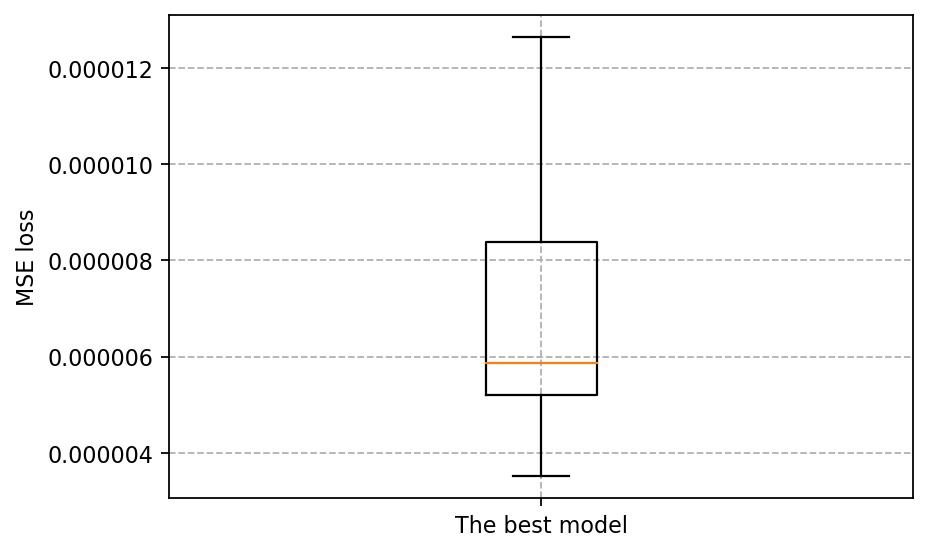

In [36]:
plt.boxplot(np.array(losses_best[0]), positions=[0], flierprops={
            "markersize": 6, "markeredgecolor": "C3"})

plt.ylabel("MSE loss")
plt.gca().set_xticklabels(["The best model"])
plt.grid(ls="--")
plt.savefig(f"{output}/profile_bestmodel.svg", bbox_inches="tight")

In [37]:
bestmodel = MappingNN(**model_params)
bestmodel = bestmodel.double()
bestmodel.load_state_dict(pt.load(f"{save_temp_best}best_model_train.pt"))
prediction = bestmodel(full_data_norm[:, 3:]).squeeze().detach()
error = (prediction - full_data_norm[:, 0:3]) / 1 * 100 # 1 - 0 = 1

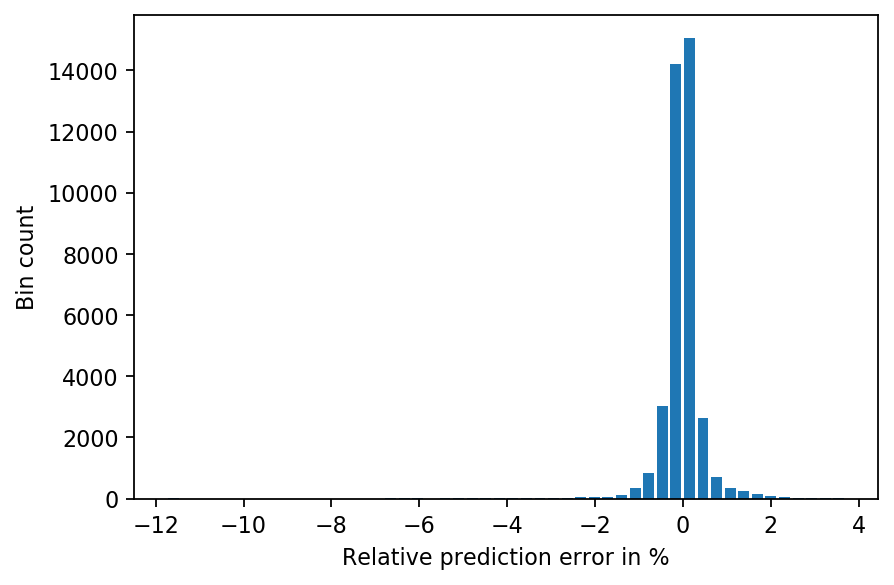

In [38]:
# Histogram for relative error
err_min = error.min().item()
err_max = error.max().item()
counts = pt.histc(error, bins=50, min=err_min, max=err_max).detach()
bin_width = (err_max-err_min) / 50
centers = pt.arange(err_min+0.5*bin_width, err_min +
                    50*bin_width, bin_width).detach()

plt.bar(centers, counts, width=bin_width*0.8)
plt.xlabel("Relative prediction error in %")
plt.ylabel("Bin count")
plt.savefig(f"{output}/profile_error_hist_best.svg", bbox_inches="tight")

In [39]:
# Heat map for maximum relative error
def max_error_map(x: pt.Tensor, err: pt.Tensor, bins: int) -> pt.Tensor:
    """Divide feature space in bins and compute maximum error for each bin.

    Parameters
    ----------
    :param x: feature tensor
    :type x: pt.Tensor
    :param err: absolute error values
    :type err: pt.Tensor
    :param bins: number of bin
    :type bins: int
    
    Return
    ------
    :return: 2D tensor with maximum errors for each bin; if there are N bins,
        the result will be a NxN tensor
    :rtype: pt.Tensor
    """
    step = 1.0 / bins
    bounds_low = pt.arange(0.0, 1.0, step)
    bounds_up = pt.arange(0.0+step, 1.0+0.5*step, step)
    max_error = pt.zeros((bins, bins))
    for i, (low_i, up_i) in enumerate(zip(bounds_low, bounds_up)):
        for j, (low_j, up_j) in enumerate(zip(bounds_low, bounds_up)):
            errors = pt.where((x[:, 0] >= low_i) & (x[:, 1] >= low_j) & (
                x[:, 0] < up_i) & (x[:, 1] < up_j), err.type(pt.float64), 0.0)
            max_error[i, j] = errors.max()
    return max_error

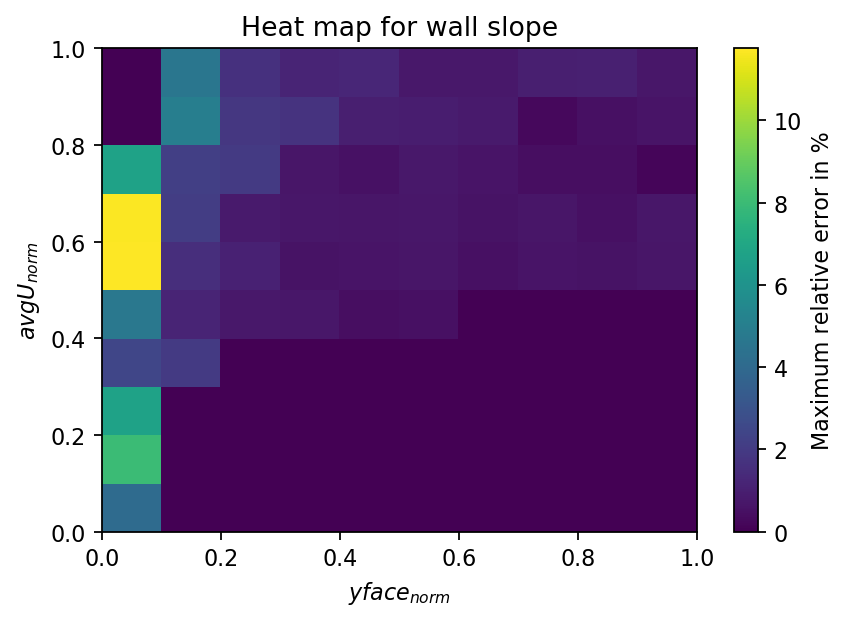

In [40]:
# Heat map for wall slope
error_map = max_error_map(full_data_norm[:, 3:], error.abs()[:, 0], 10)
edges = pt.linspace(0, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges)
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.title("Heat map for wall slope")
plt.colorbar(pcol, label=r"Maximum relative error in %")
plt.xlabel(r"$yface_{norm}$")
plt.ylabel(r"$avgU_{norm}$")
plt.savefig(f"{output}/profile_error_heatmap_wallslope.svg", bbox_inches="tight")

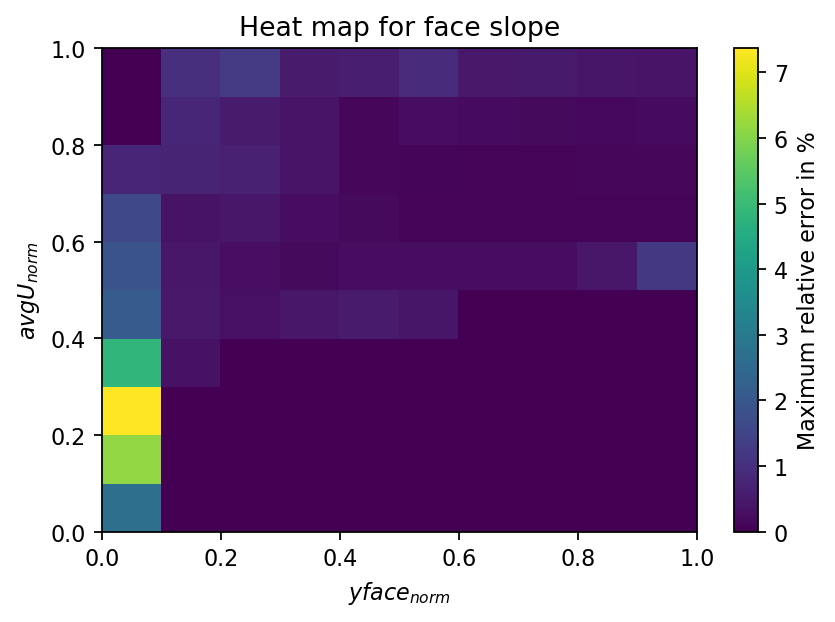

In [41]:
# Heat map for face slope
error_map = max_error_map(full_data_norm[:, 3:], error.abs()[:, 1], 10)
edges = pt.linspace(0, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges)
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.title("Heat map for face slope")
plt.colorbar(pcol, label=r"Maximum relative error in %")
plt.xlabel(r"$yface_{norm}$")
plt.ylabel(r"$avgU_{norm}$")
plt.savefig(f"{output}/profile_error_heatmap_faceslope.svg", bbox_inches="tight")

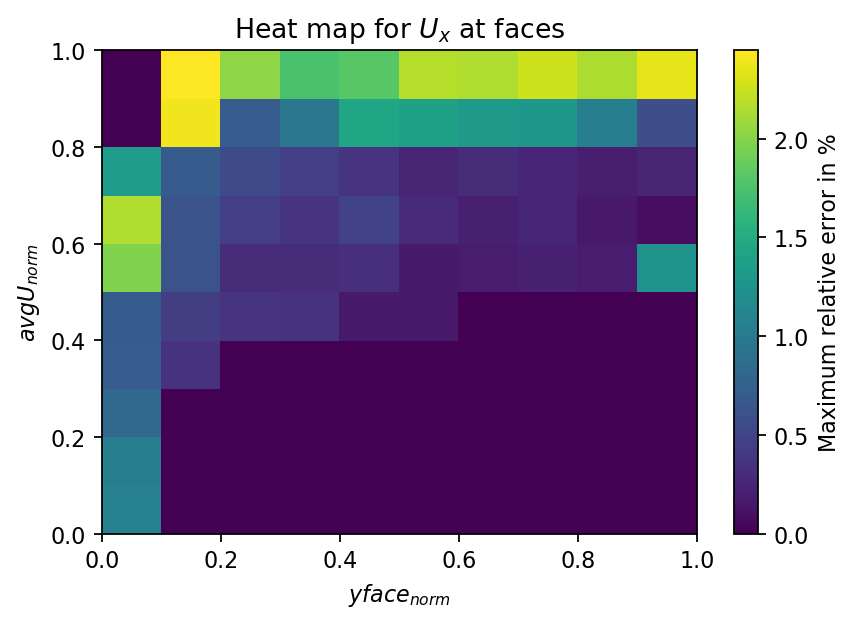

In [42]:
# Heat map for Ux at faces
error_map = max_error_map(full_data_norm[:, 3:], error.abs()[:, 2], 10)
edges = pt.linspace(0, 1, 10+1)
xx, yy = pt.meshgrid(edges, edges)
pcol = plt.pcolormesh(xx.detach(), yy.detach(), error_map.detach())
plt.title(r"Heat map for $U_x$ at faces")
plt.colorbar(pcol, label=r"Maximum relative error in %")
plt.xlabel(r"$yface_{norm}$")
plt.ylabel(r"$avgU_{norm}$")
plt.savefig(f"{output}/profile_error_heatmap_Uxface.svg", bbox_inches="tight")